In [1]:
# Load the sentiment analysis dataset
from datasets import load_dataset, Dataset, DatasetDict
dataset = load_dataset("cardiffnlp/tweet_eval", "sentiment")

In [2]:
from transformers import AutoTokenizer

# Load GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the data
def preprocess_function(examples):
    tokenized = tokenizer(
        examples['text'],
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )
    tokenized["labels"] = examples["label"]  # Add labels to the tokenized dataset
    return tokenized

tokenized_datasets = dataset.map(preprocess_function, batched=True)

In [3]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [4]:
from transformers import AutoModelForSequenceClassification

import torch

# Set the device to MPS explicitly
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Load GPT-2 with a classification head
model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=3) 
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=3, bias=False)
)

In [5]:
from peft import get_peft_model, LoraConfig
lora_config = LoraConfig(
    task_type="SEQ_CLS",
    r=8,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(model, lora_config)

/Users/srinathsureshkumar/miniconda3/envs/bda/lib/python3.12/site-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [6]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate the model at the end of each epoch
    save_strategy="epoch",  # Save the model at the end of each epoch (to match evaluation strategy)
    learning_rate=5e-5,
    per_device_train_batch_size=8,  # Adjust batch size if necessary
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir="./logs",
    save_total_limit=2,
    gradient_accumulation_steps=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

/Users/srinathsureshkumar/miniconda3/envs/bda/lib/python3.12/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/_v/9p5rkkbj79d0bmthxllw7rqm0000gn/T/ipykernel_52354/3537546471.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [7]:
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

  0%|          | 0/384 [00:00<?, ?it/s]

Tweet Accuracy: 0.48282318463041357
Tweet Precision: 0.5684618985067416
Tweet Recall: 0.3331917714579435
Tweet F1 Score: 0.21799466701308992
Tweet Accuracy: 0.48282318463041357


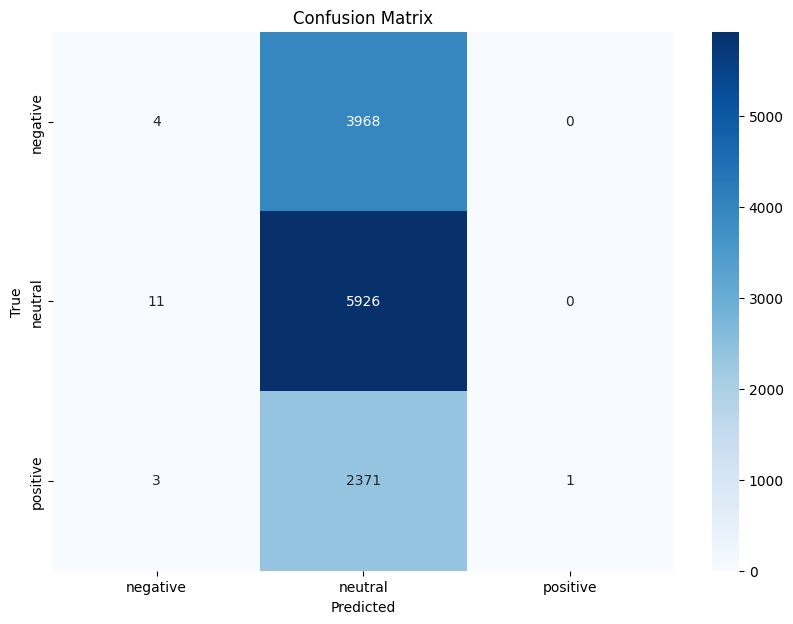

In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
trainer.train()

  0%|          | 0/8553 [00:00<?, ?it/s]

{'loss': 3.656, 'grad_norm': 24.03085708618164, 'learning_rate': 5e-05, 'epoch': 0.18}
{'loss': 1.6347, 'grad_norm': 12.600005149841309, 'learning_rate': 4.689556686948963e-05, 'epoch': 0.35}
{'loss': 1.4379, 'grad_norm': 15.268843650817871, 'learning_rate': 4.379113373897926e-05, 'epoch': 0.53}
{'loss': 1.4137, 'grad_norm': 11.485063552856445, 'learning_rate': 4.06867006084689e-05, 'epoch': 0.7}
{'loss': 1.3457, 'grad_norm': 15.955217361450195, 'learning_rate': 3.7582267477958524e-05, 'epoch': 0.88}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.6757861375808716, 'eval_model_preparation_time': 0.0016, 'eval_runtime': 24.1339, 'eval_samples_per_second': 82.871, 'eval_steps_per_second': 2.61, 'epoch': 1.0}
{'loss': 1.3475, 'grad_norm': 24.471221923828125, 'learning_rate': 3.4477834347448155e-05, 'epoch': 1.05}
{'loss': 1.3538, 'grad_norm': 16.32180404663086, 'learning_rate': 3.1373401216937785e-05, 'epoch': 1.23}
{'loss': 1.3266, 'grad_norm': 12.360506057739258, 'learning_rate': 2.8268968086427423e-05, 'epoch': 1.4}
{'loss': 1.2802, 'grad_norm': 9.152953147888184, 'learning_rate': 2.5164534955917053e-05, 'epoch': 1.58}
{'loss': 1.2948, 'grad_norm': 18.629789352416992, 'learning_rate': 2.206010182540668e-05, 'epoch': 1.75}
{'loss': 1.3076, 'grad_norm': 25.124162673950195, 'learning_rate': 1.8955668694896314e-05, 'epoch': 1.93}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.648330807685852, 'eval_model_preparation_time': 0.0016, 'eval_runtime': 24.0053, 'eval_samples_per_second': 83.315, 'eval_steps_per_second': 2.624, 'epoch': 2.0}
{'loss': 1.3036, 'grad_norm': 15.239607810974121, 'learning_rate': 1.5851235564385944e-05, 'epoch': 2.1}
{'loss': 1.2903, 'grad_norm': 13.09762954711914, 'learning_rate': 1.2746802433875573e-05, 'epoch': 2.28}
{'loss': 1.2784, 'grad_norm': 12.064580917358398, 'learning_rate': 9.642369303365207e-06, 'epoch': 2.46}
{'loss': 1.2469, 'grad_norm': 22.329954147338867, 'learning_rate': 6.5379361728548376e-06, 'epoch': 2.63}
{'loss': 1.2842, 'grad_norm': 9.956747055053711, 'learning_rate': 3.433503042344468e-06, 'epoch': 2.81}
{'loss': 1.273, 'grad_norm': 8.63259220123291, 'learning_rate': 3.290699118340991e-07, 'epoch': 2.98}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.6407042741775513, 'eval_model_preparation_time': 0.0016, 'eval_runtime': 24.5158, 'eval_samples_per_second': 81.58, 'eval_steps_per_second': 2.57, 'epoch': 3.0}
{'train_runtime': 4497.6183, 'train_samples_per_second': 30.426, 'train_steps_per_second': 1.902, 'train_loss': 1.473730250741813, 'epoch': 3.0}


TrainOutput(global_step=8553, training_loss=1.473730250741813, metrics={'train_runtime': 4497.6183, 'train_samples_per_second': 30.426, 'train_steps_per_second': 1.902, 'total_flos': 9024845791887360.0, 'train_loss': 1.473730250741813, 'epoch': 3.0})

In [10]:
# Evaluate the model
results = trainer.evaluate(tokenized_datasets["test"])
print(results)

# Save the fine-tuned model
model.save_pretrained("./lora-sentiment-gpt2")
tokenizer.save_pretrained("./lora-sentiment-gpt2")

  0%|          | 0/384 [00:00<?, ?it/s]

{'eval_loss': 0.6686538457870483, 'eval_model_preparation_time': 0.0016, 'eval_runtime': 150.0573, 'eval_samples_per_second': 81.862, 'eval_steps_per_second': 2.559, 'epoch': 3.0}


('./lora-sentiment-gpt2/tokenizer_config.json',
 './lora-sentiment-gpt2/special_tokens_map.json',
 './lora-sentiment-gpt2/vocab.json',
 './lora-sentiment-gpt2/merges.txt',
 './lora-sentiment-gpt2/added_tokens.json',
 './lora-sentiment-gpt2/tokenizer.json')

  0%|          | 0/384 [00:00<?, ?it/s]

Tweet Accuracy: 0.6988765874308043
Tweet Precision: 0.6888710256828828
Tweet Recall: 0.714364027104298
Tweet F1 Score: 0.6987630838778603
Tweet Accuracy: 0.6988765874308043


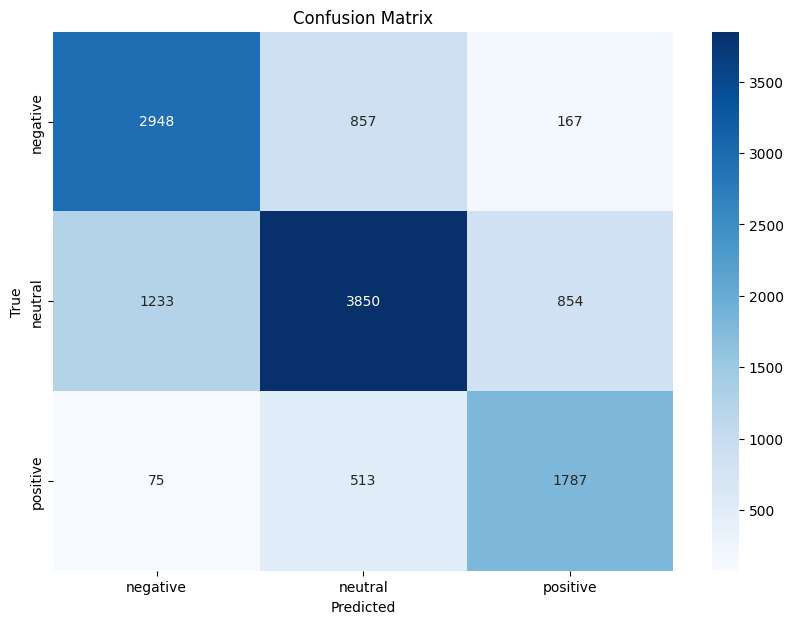

In [11]:
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
dataset = load_dataset("cardiffnlp/super_tweeteval", "tweet_sentiment")
label_mapping = {0: 0, 1: 0, 2: 1, 3: 2, 4: 2}  

def replace_labels(examples, label_mapping):
    examples['label'] = [label_mapping[label] for label in examples['gold_label']]
    return examples

# Replace labels in the dataset using the mapping
dataset = dataset.map(lambda examples: replace_labels(examples, label_mapping), batched=True)


In [ ]:

tokenizer = AutoTokenizer.from_pretrained("./lora-sentiment-gpt2")
tokenizer.pad_token = tokenizer.eos_token



Map:   0%|          | 0/12379 [00:00<?, ? examples/s]

In [ ]:
def preprocess_function(examples):
    tokenized = tokenizer(
        examples['text'],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tokenized["labels"] = examples["label"]  
    return tokenized

tokenized_datasets = dataset.map(preprocess_function, batched=True)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("./lora-sentiment-gpt2", num_labels=3) 
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): lora.Linear(
            (base_layer): Conv1D(nf=2304, nx=768)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=768, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=2304, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (c_proj): lora.Linear(
            (base_layer): Conv1D(nf=768, nx=

In [16]:
from peft import get_peft_model, LoraConfig
lora_config = LoraConfig(
    task_type="SEQ_CLS",
    r=8,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(model, lora_config)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  
    save_strategy="epoch",  
    learning_rate=5e-5,
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir="./logs",
    save_total_limit=2,
    gradient_accumulation_steps=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

/Users/srinathsureshkumar/miniconda3/envs/bda/lib/python3.12/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/_v/9p5rkkbj79d0bmthxllw7rqm0000gn/T/ipykernel_52354/149155787.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
trainer.train()

  0%|          | 0/4992 [00:00<?, ?it/s]

{'loss': 1.3922, 'grad_norm': 15.14926815032959, 'learning_rate': 5e-05, 'epoch': 0.3}
{'loss': 1.3772, 'grad_norm': 22.66634750366211, 'learning_rate': 4.443455031166518e-05, 'epoch': 0.6}
{'loss': 1.3635, 'grad_norm': 49.74971389770508, 'learning_rate': 3.886910062333037e-05, 'epoch': 0.9}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.7983646392822266, 'eval_runtime': 47.9772, 'eval_samples_per_second': 83.373, 'eval_steps_per_second': 2.605, 'epoch': 1.0}
{'loss': 1.3669, 'grad_norm': 64.76769256591797, 'learning_rate': 3.330365093499555e-05, 'epoch': 1.2}
{'loss': 1.3452, 'grad_norm': 29.798002243041992, 'learning_rate': 2.7738201246660732e-05, 'epoch': 1.5}
{'loss': 1.3465, 'grad_norm': 29.75984001159668, 'learning_rate': 2.2172751558325912e-05, 'epoch': 1.8}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.802060067653656, 'eval_runtime': 48.4333, 'eval_samples_per_second': 82.588, 'eval_steps_per_second': 2.581, 'epoch': 2.0}
{'loss': 1.3072, 'grad_norm': 15.118168830871582, 'learning_rate': 1.6607301869991096e-05, 'epoch': 2.1}
{'loss': 1.2968, 'grad_norm': 10.805123329162598, 'learning_rate': 1.1041852181656279e-05, 'epoch': 2.4}
{'loss': 1.3037, 'grad_norm': 14.878681182861328, 'learning_rate': 5.476402493321461e-06, 'epoch': 2.7}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.8133711218833923, 'eval_runtime': 47.1165, 'eval_samples_per_second': 84.896, 'eval_steps_per_second': 2.653, 'epoch': 3.0}
{'train_runtime': 2756.5169, 'train_samples_per_second': 28.984, 'train_steps_per_second': 1.811, 'train_loss': 1.3434572097582695, 'epoch': 3.0}


TrainOutput(global_step=4992, training_loss=1.3434572097582695, metrics={'train_runtime': 2756.5169, 'train_samples_per_second': 28.984, 'train_steps_per_second': 1.811, 'total_flos': 5620999353532416.0, 'train_loss': 1.3434572097582695, 'epoch': 2.9990988284770204})

In [20]:
# Evaluate the model
results = trainer.evaluate(tokenized_datasets["test"])
print(results)

# Save the fine-tuned model
model.save_pretrained("./lora-sentiment-gpt2-2")
tokenizer.save_pretrained("./lora-sentiment-gpt2-2")

  0%|          | 0/387 [00:00<?, ?it/s]

{'eval_loss': 0.768048882484436, 'eval_runtime': 147.9436, 'eval_samples_per_second': 83.674, 'eval_steps_per_second': 2.616, 'epoch': 2.9990988284770204}


('./lora-sentiment-gpt2-2/tokenizer_config.json',
 './lora-sentiment-gpt2-2/special_tokens_map.json',
 './lora-sentiment-gpt2-2/vocab.json',
 './lora-sentiment-gpt2-2/merges.txt',
 './lora-sentiment-gpt2-2/added_tokens.json',
 './lora-sentiment-gpt2-2/tokenizer.json')

  0%|          | 0/387 [00:00<?, ?it/s]

Tweet Accuracy: 0.6416511834558527
Tweet Precision: 0.6325269886462349
Tweet Recall: 0.6473843193039349
Tweet F1 Score: 0.6364508483863139
Tweet Accuracy: 0.6416511834558527


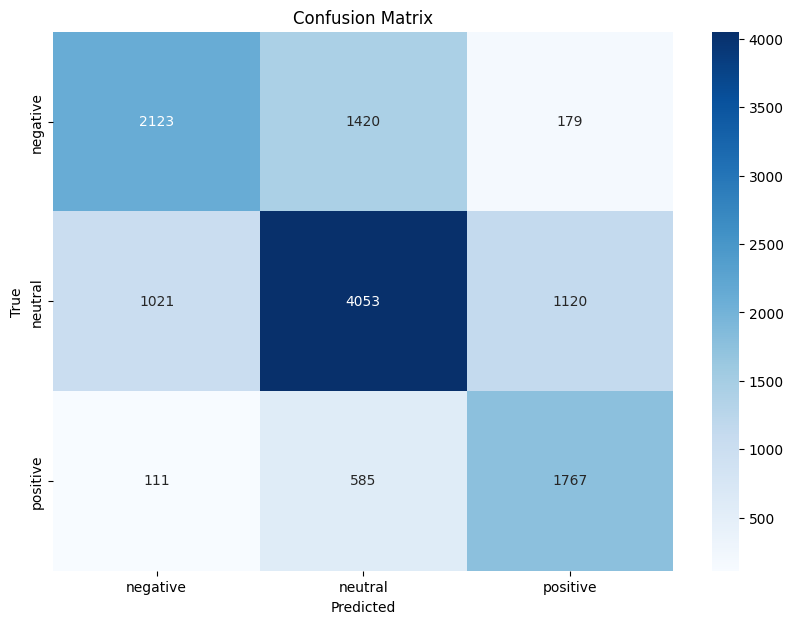

In [21]:
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict

reddit_df = pd.read_csv('the-reddit-dataset-dataset-comments.csv')
reddit_df = reddit_df.dropna(subset=['body', 'sentiment'])
reddit_df['body'] = reddit_df['body'].astype(str)
reddit_df['sentiment'] = reddit_df['sentiment'].astype(float)
def assign_label(score):
    if score < -0.5:
        return 0  # Negative
    elif -0.5 <= score <= 0.5:
        return 1  # Neutral
    else:
        return 2  # Positive

reddit_df['text'] = reddit_df['body']
reddit_df['label'] = reddit_df['sentiment'].apply(assign_label)
reddit_df = reddit_df[['text', 'label']]
reddit_data = Dataset.from_pandas(reddit_df)


reddit_dataset = DatasetDict({
    'test': reddit_data
})

In [ ]:
reddit_tokenized_datasets = reddit_dataset.map(preprocess_function, batched=True)
predictions = trainer.predict(reddit_tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

accuracy = accuracy_score(reddit_tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(reddit_tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(reddit_tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(reddit_tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Reddit Accuracy: {accuracy}')
print(f'Reddit Precision: {precision}')
print(f'Reddit Recall: {recall}')
print(f'Reddit F1 Score: {f1_score_}')
print(f'Reddit Accuracy: {accuracy}')


Map:   0%|          | 0/47370 [00:00<?, ? examples/s]

  0%|          | 0/1481 [00:00<?, ?it/s]

Reddit Accuracy: 0.6310745197382309
Reddit Precision: 0.5220372959963712
Reddit Recall: 0.514856056942795
Reddit F1 Score: 0.5140860643648747
Reddit Accuracy: 0.6310745197382309


ValueError: Found input variables with inconsistent numbers of samples: [12379, 47370]

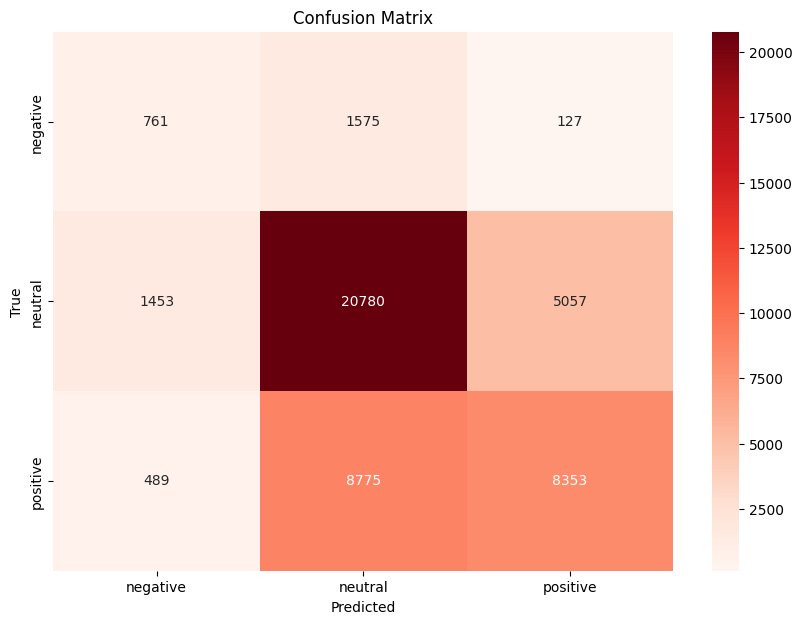

In [24]:

conf_matrix = confusion_matrix(reddit_tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [10]:

from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('all_sampled_twitter.csv')

# Split the DataFrame into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [20]:

from transformers import GPT2ForSequenceClassification, GPT2Tokenizer

import torch

# Set the device to MPS explicitly
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model_checkpoint = './sentiment-gpt2-2'
tokenizer = GPT2Tokenizer.from_pretrained(model_checkpoint)
model = GPT2ForSequenceClassification.from_pretrained(model_checkpoint)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

In [21]:



# Tokenize the data
def preprocess_function(examples):
    tokenized = tokenizer(
        examples['text'],
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )
    tokenized["labels"] = examples["label"]  # Add labels to the tokenized dataset
    return tokenized

tokenized_datasets = dataset.map(preprocess_function, batched=True)

from peft import get_peft_model, LoraConfig
lora_config = LoraConfig(
    task_type="SEQ_CLS",
    r=8,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(model, lora_config)
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate the model at the end of each epoch
    save_strategy="epoch",  # Save the model at the end of each epoch (to match evaluation strategy)
    learning_rate=5e-5,
    per_device_train_batch_size=8,  # Adjust batch size if necessary
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir="./logs",
    save_total_limit=2,
    gradient_accumulation_steps=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

Map:   0%|          | 0/5246 [00:00<?, ? examples/s]

Map:   0%|          | 0/1749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1749 [00:00<?, ? examples/s]

/Users/srinathsureshkumar/miniconda3/envs/bda/lib/python3.12/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/_v/9p5rkkbj79d0bmthxllw7rqm0000gn/T/ipykernel_60469/1190388977.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Map:   0%|          | 0/5246 [00:00<?, ? examples/s]

Map:   0%|          | 0/1749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1749 [00:00<?, ? examples/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Tweet Accuracy: 0.7501429388221841
Tweet Precision: 0.7651695680221285
Tweet Recall: 0.7584665780811354
Tweet F1 Score: 0.7455220403789472
Tweet Accuracy: 0.7501429388221841


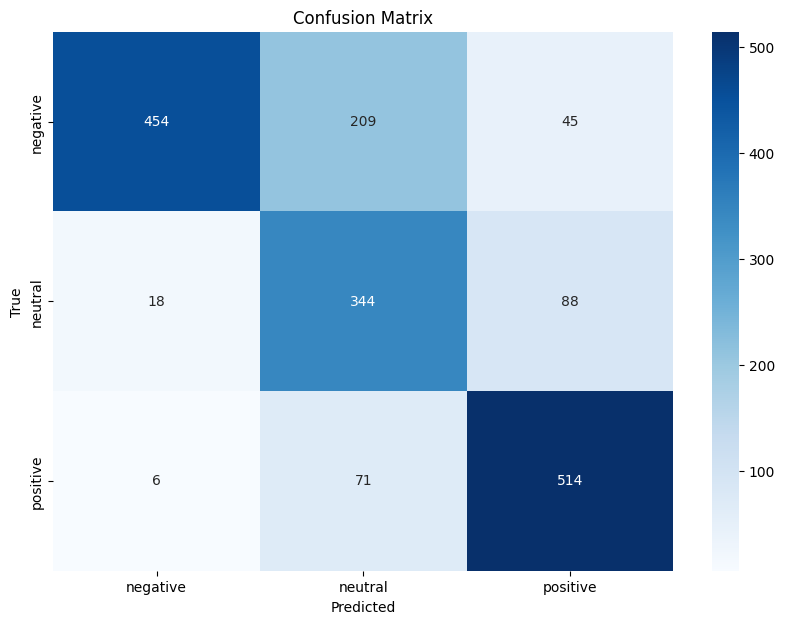

In [22]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()